In [1]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [3]:
x_train, y_train = x_train[:5000], y_train[:5000]   # just first 5k samples
x_test, y_test = x_test[:1000], y_test[:1000]

In [4]:
x_train, y_train = x_train[:5000], y_train[:5000]   # just first 5k samples
x_test, y_test = x_test[:1000], y_test[:1000]

In [5]:
class_names = [
    "airplane", "automobile", "bird", "cat",
    "deer", "dog", "frog", "horse", "ship", "truck"
]

In [6]:
df = pd.DataFrame({
    "Label_ID": list(range(10)),
    "Label_Name": class_names
})
df

,Label_ID,Label_Name
0,0,airplane
1,1,automobile
2,2,bird
3,3,cat
4,4,deer
5,5,dog
6,6,frog
7,7,horse
8,8,ship
9,9,truck


In [7]:
df.head(5)

,Label_ID,Label_Name
0,0,airplane
1,1,automobile
2,2,bird
3,3,cat
4,4,deer


In [8]:
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))   # resize PER IMAGE (batch)
    image = preprocess_input(image)               # normalize
    label = tf.one_hot(label, 10)                 # one-hot encode
    label = tf.squeeze(label, axis=0)
    return image, label

batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [9]:
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [10]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10
)


Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 170ms/step - accuracy: 0.4116 - loss: 1.8088 - val_accuracy: 0.8080 - val_loss: 0.5736
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.7935 - loss: 0.5741 - val_accuracy: 0.8550 - val_loss: 0.4549
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 103ms/step - accuracy: 0.8563 - loss: 0.4361 - val_accuracy: 0.8580 - val_loss: 0.4166
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.8820 - loss: 0.3636 - val_accuracy: 0.8860 - val_loss: 0.3858
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.8861 - loss: 0.3314 - val_accuracy: 0.8660 - val_loss: 0.3875
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 0.8969 - loss: 0.3116 - val_accuracy: 0.8700 - val_loss: 0.3741
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 106ms/step - accuracy: 0.9122 - loss: 0.2520 - val_accuracy: 0.8810 - val_loss: 0.3578
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 105ms/step - accuracy: 0.9172 - loss: 0

In [11]:
loss, acc = model.evaluate(test_ds)
print("Test Accuracy:", acc)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.8790 - loss: 0.3437
Test Accuracy: 0.8870000243186951


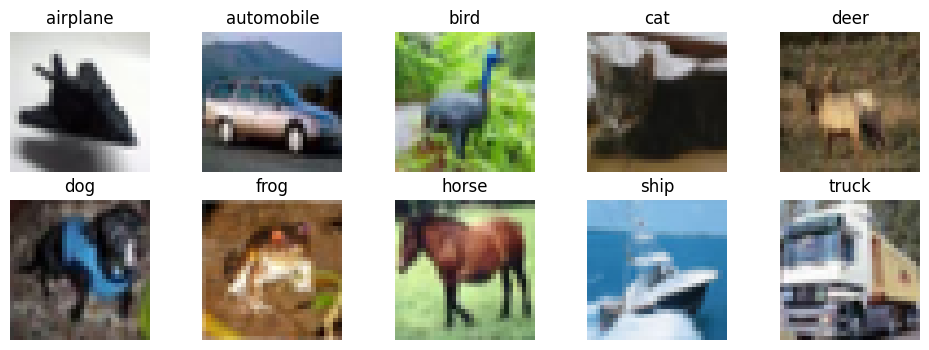

In [12]:
plt.figure(figsize=(12, 4))

for i in range(10):
    idx = np.where(y_train == i)[0][0]
    plt.subplot(2, 5, i+1)
    plt.imshow(x_train[idx])
    plt.title(class_names[i])
    plt.axis("off")

plt.show()


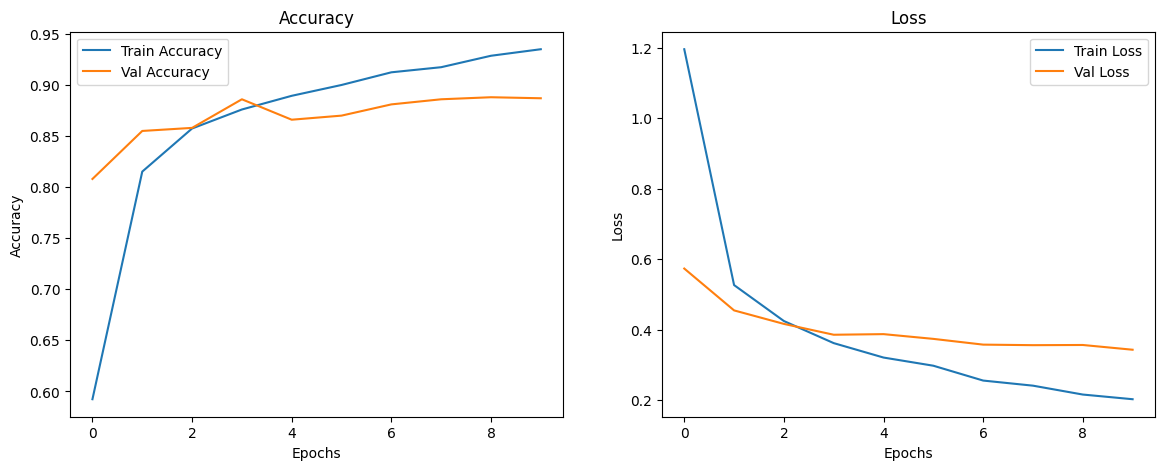

In [13]:
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


Saving istockphoto-175397603-612x612.jpg to istockphoto-175397603-612x612.jpg


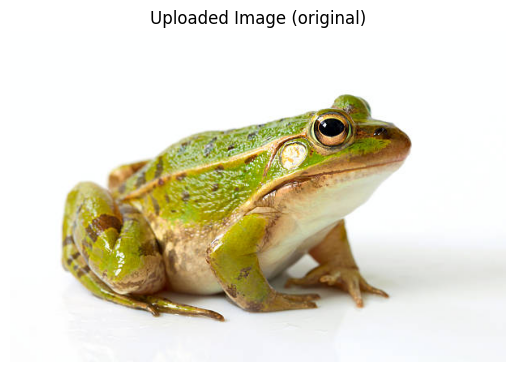

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Top-3 predictions:
  frog — 1.0000
  automobile — 0.0000
  bird — 0.0000


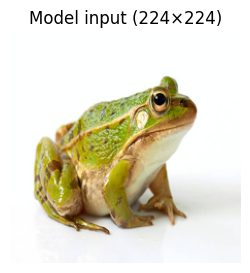

In [14]:
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

def predict_uploaded_image_topk(top_k=3):
    uploaded = files.upload()
    for name in uploaded.keys():
        # Load and convert to RGB
        img = Image.open(name).convert('RGB')
        plt.imshow(img)
        plt.title("Uploaded Image (original)")
        plt.axis('off')
        plt.show()

        # Resize to 224x224 (ResNet50 input)
        img_resized = img.resize((224, 224))
        img_array = np.array(img_resized).astype(np.float32)

        # Prepare batch: apply ResNet50 preprocess_input (imagenet style)
        batch = np.expand_dims(img_array, axis=0)
        batch = preprocess_input(batch)    # important!

        # Predict
        preds = model.predict(batch)[0]    # shape (10,)
        top_indices = preds.argsort()[-top_k:][::-1]
        print("Top-{} predictions:".format(top_k))
        for idx in top_indices:
            print(f"  {class_names[idx]} — {preds[idx]:.4f}")

        # Optionally show the resized image the model actually saw
        plt.figure(figsize=(3,3))
        plt.imshow(img_resized)
        plt.title("Model input (224×224)")
        plt.axis('off')
        plt.show()

# Run function to upload & predict
predict_uploaded_image_topk(top_k=3)


Saving aeroplane.jpg to aeroplane.jpg


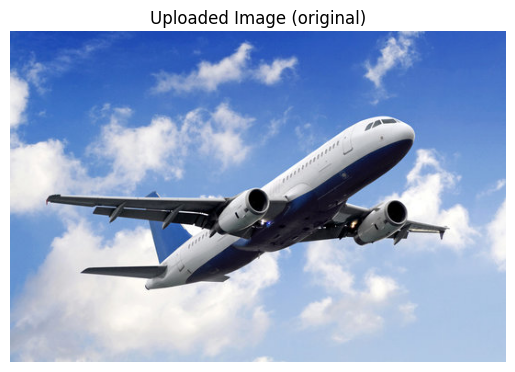

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Top-3 predictions:
  airplane — 0.9997
  bird — 0.0001
  truck — 0.0001


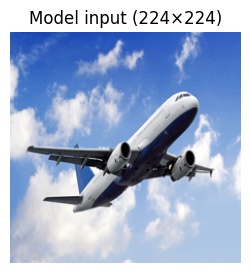

In [15]:
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input
import tensorflow as tf

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

def predict_uploaded_image_topk(top_k=3):
    uploaded = files.upload()
    for name in uploaded.keys():
        # Load and convert to RGB
        img = Image.open(name).convert('RGB')
        plt.imshow(img)
        plt.title("Uploaded Image (original)")
        plt.axis('off')
        plt.show()

        # Resize to 224x224 (ResNet50 input)
        img_resized = img.resize((224, 224))
        img_array = np.array(img_resized).astype(np.float32)

        # Prepare batch: apply ResNet50 preprocess_input (imagenet style)
        batch = np.expand_dims(img_array, axis=0)
        batch = preprocess_input(batch)    # important!

        # Predict
        preds = model.predict(batch)[0]    # shape (10,)
        top_indices = preds.argsort()[-top_k:][::-1]
        print("Top-{} predictions:".format(top_k))
        for idx in top_indices:
            print(f"  {class_names[idx]} — {preds[idx]:.4f}")

        # Optionally show the resized image the model actually saw
        plt.figure(figsize=(3,3))
        plt.imshow(img_resized)
        plt.title("Model input (224×224)")
        plt.axis('off')
        plt.show()

# Run function to upload & predict
predict_uploaded_image_topk(top_k=3)